In [78]:
import numpy as np
import pandas as pd
import rdkit
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
from spectrum_func import *


import mordred
from mordred import Calculator, descriptors

In [2]:
optdata = pd.read_csv("data/DB for chromophore_Sci_Data_rev02.csv")
optdata.columns = ['Tag', 'Chromophore', 'Solvent', 'LambdaMaxAbs', 'LambdaMaxEm', 'Lifetime', 'QY', 'LogExtCoeff', 'AbsFWHMcm-1', 'EmFWHMcm-1', 'AbsFWHMnm', 'EmFWHMnm', 'MolarMass', 'reference']
features_start_at = list(optdata.columns).index("LambdaMaxAbs")
# scramble them
optdata = optdata.sample(frac=1.0, random_state=0).reset_index(drop=True)
optdata.head()

,Tag,Chromophore,Solvent,LambdaMaxAbs,LambdaMaxEm,Lifetime,QY,LogExtCoeff,AbsFWHMcm-1,EmFWHMcm-1,AbsFWHMnm,EmFWHMnm,MolarMass,reference
0,16295,[O-]c1c(-c2ccccc2)cc(-[n+]2c(-c3ccccc3)cc(-c3c...,Cc1ccncc1,723.822785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,551.68726,https://doi.org/10.1021/cr00032a005
1,5187,CN(C)c1ccc(C2=Cc3c4ccccc4cc[n+]3[B-](F)(F)O2)cc1,CC#N,458.000000,552.0,NaN,0.6380,4.522444,3326.0,2672.5,NaN,NaN,338.16398,https://doi.org/10.1016/j.saa.2018.03.048
2,8308,COc1cccc2cc(-c3cc4cccc(OC)c4oc3=O)oc12,CS(C)=O,359.000000,488.0,NaN,0.1100,4.457882,NaN,NaN,NaN,NaN,322.31516,DOI: 10.1021/acs.orglett.7b00069
3,11000,Cc1cc(-c2ccc(C(C)(C)C)cc2)cc(C)[o+]1,ClCCl,365.000000,417.0,2.1,0.2500,4.531479,3617.0,NaN,NaN,NaN,241.35274,https://doi.org/10.1016/S0009-2614(97)00140-1
4,13139,C(=C/c1cnc2ccccc2n1)\c1cnccn1,ClCCl,NaN,430.0,NaN,0.0014,NaN,NaN,NaN,NaN,NaN,234.26140,https://doi.org/10.1016/1010-6030(92)85164-P


In [3]:
working_df = optdata.copy()
working_df.head()


,Tag,Chromophore,Solvent,LambdaMaxAbs,LambdaMaxEm,Lifetime,QY,LogExtCoeff,AbsFWHMcm-1,EmFWHMcm-1,AbsFWHMnm,EmFWHMnm,MolarMass,reference
0,16295,[O-]c1c(-c2ccccc2)cc(-[n+]2c(-c3ccccc3)cc(-c3c...,Cc1ccncc1,723.822785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,551.68726,https://doi.org/10.1021/cr00032a005
1,5187,CN(C)c1ccc(C2=Cc3c4ccccc4cc[n+]3[B-](F)(F)O2)cc1,CC#N,458.000000,552.0,NaN,0.6380,4.522444,3326.0,2672.5,NaN,NaN,338.16398,https://doi.org/10.1016/j.saa.2018.03.048
2,8308,COc1cccc2cc(-c3cc4cccc(OC)c4oc3=O)oc12,CS(C)=O,359.000000,488.0,NaN,0.1100,4.457882,NaN,NaN,NaN,NaN,322.31516,DOI: 10.1021/acs.orglett.7b00069
3,11000,Cc1cc(-c2ccc(C(C)(C)C)cc2)cc(C)[o+]1,ClCCl,365.000000,417.0,2.1,0.2500,4.531479,3617.0,NaN,NaN,NaN,241.35274,https://doi.org/10.1016/S0009-2614(97)00140-1
4,13139,C(=C/c1cnc2ccccc2n1)\c1cnccn1,ClCCl,NaN,430.0,NaN,0.0014,NaN,NaN,NaN,NaN,NaN,234.26140,https://doi.org/10.1016/1010-6030(92)85164-P


In [4]:
optdata_LambdaMaxAbs = working_df[(~working_df["LambdaMaxAbs"].isna())]
optdata_LogExtCoeff = working_df[(~working_df["LogExtCoeff"].isna())]
working_df_LogExtCoeff = optdata_LogExtCoeff.copy()
working_df_LambdaMaxAbs = optdata_LambdaMaxAbs.copy()

In [5]:
optdata_LogExtCoeff.index

Int64Index([    1,     2,     3,     6,    10,    11,    13,    17,    18,
               19,
            ...
            20219, 20221, 20223, 20224, 20228, 20229, 20230, 20232, 20233,
            20234],
           dtype='int64', length=8041)

In [6]:
# Define a list of descriptor groups to exclude
exclude_groups = ['MoreauBrotoAutocorrelation', 'GearyAuto', 'MoranAuto', 'BaryszMatrix']

# Remove the undesired descriptor groups from the list of descriptors
descriptors_to_use = []
for desc in descriptors.__all__:
    if desc not in exclude_groups:
        descriptors_to_use.append(getattr(descriptors, desc))

# Make object that can compute descriptors
calc = Calculator(descriptors_to_use, ignore_3D=True)


In [7]:

def get_mol_and_labels(calculators, df, property, filepath):
    # Load molecules from valid SMILES strings
    molecules = []
    labels = []
    for i, smi in zip(df.index, df.Chromophore):
        mol = rdkit.Chem.MolFromSmiles(smi)
        if mol:
            molecules.append(mol)
            labels.append(df.loc[i][property])

    # calculating mordred features is time consuming so we work with precalculated features
    try:
        raw_features = pd.read_pickle(filepath)
    except FileNotFoundError as e:
        raw_features = calculators.pandas(molecules, nproc=8, quiet=False)
        raw_features.to_pickle(filepath)
    
    return molecules, labels, raw_features

In [8]:

molecules_lec, labels_lec, raw_features_lec = get_mol_and_labels(calc, working_df_LogExtCoeff, "LogExtCoeff", "data/raw_features_lec.pb")
molecules_lma, labels_lma, raw_features_lma = get_mol_and_labels(calc, working_df_LambdaMaxAbs, "LambdaMaxAbs", "data/raw_features_lma.pb")

In [9]:
# load tag list to df
taglist = pd.read_csv("data/fluorene_tag_list.csv")



## Explore molecules to be used as base molecules. <br>
### Here we plug into the code a smiles string for the substructure we are looking for. In this case we look at fluorenes so let's define our fluorene SMILES. Then we need to use the SMARTS string for that substructure to find any molecules in our dataset that contain this substructure.

In [10]:
def smarts_from_substructure_smiles(substructure_smiles):
    substructure_mol = rdkit.Chem.MolFromSmiles(substructure_smiles)
    substructure_smarts = rdkit.Chem.MolToSmarts(substructure_mol)
    print (f"substructure_smarts is {substructure_smarts}")
    substructure_mol = rdkit.Chem.MolFromSmarts(substructure_smarts)
    return substructure_mol, substructure_smarts

substructure_smarts is [#6]1-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2-[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2-1


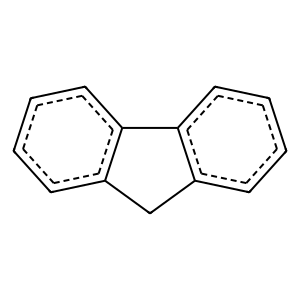

In [11]:
# Input the smiles string of interest:
fluorene_smiles = 'C1C2=CC=CC=C2C3=CC=CC=C31'
fluorene_mol, fluorene_smarts = smarts_from_substructure_smiles(fluorene_smiles)
# Then plot the substructure to check it is correct (visually)
rdkit.Chem.Draw.MolToImage(fluorene_mol)


CCN(CC)c2ccc(C=c1ccc(=C(Cl)Cl)s1)cc2
substructure_smarts is [#6]1:[#6]:[#6]:[#6](-[#6]=[#6]2:[#6]:[#6]:[#6](=[#6]):[#16]:2):[#6]:[#6]:1
quinoidal_thiophene_smarts is [#6]1:[#6]:[#6]:[#6](-[#6]=[#6]2:[#6]:[#6]:[#6](=[#6]):[#16]:2):[#6]:[#6]:1


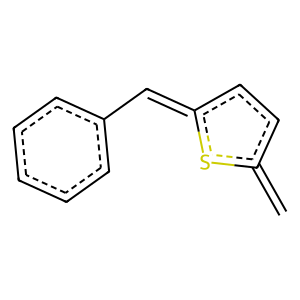

In [90]:
print ("CCN(CC)c2ccc(C=c1ccc(=C(Cl)Cl)s1)cc2")
# Input the smiles string of interest:
quinoidal_thiophene_smiles = 'c2ccc(C=c1ccc(=C)s1)cc2'
quinoidal_thiophene_mol, quinoidal_thiophene_smarts = smarts_from_substructure_smiles(quinoidal_thiophene_smiles)
print (f"quinoidal_thiophene_smarts is {quinoidal_thiophene_smarts}")
# Then plot the substructure to check it is correct (visually)
rdkit.Chem.Draw.MolToImage(quinoidal_thiophene_mol)

## Index the compounds with the substructures that we may wish to preserve

In [12]:
def substructure_preserver(mol, substructure):
    """
    Check for substructure violates
    Return True: contains a substructure violation
    Return False: No substructure violation
    """        
    
    if mol.HasSubstructMatch(rdkit.Chem.MolFromSmarts(substructure)) == True:
        return True # The has substructure! 
    else: 
        return False # Molecule does not have substructure!

In [13]:
def df_of_smarts(df, smarts):

    # return iloc from data for each entry that has mol.HasSubstructMatch(rdkit.Chem.MolFromSmarts(fluorene)) == True
    # first convert smiles to mol for each row, working with optdata_LogExtCoeff
    # THis code also adds a mol object to the substructure df

    df['mol'] = df['Chromophore'].apply(lambda x: rdkit.Chem.MolFromSmiles(x))
    df['substructure_present'] = df['mol'].apply(lambda x: substructure_preserver(x, smarts))
    df['substructure_present'].value_counts()

    # Reset the index
    df.reset_index(drop=True, inplace=True)

    # Find the iloc values of the molecules that have the substructure
    substructure_present = df[df['substructure_present'] == True].index.tolist()
    substructure_df = df.iloc[substructure_present]
    print (f"The number of entries with this smarts fragment present is {len(substructure_df)} of {len(df)}")
    return (substructure_df)



##  And here we build a df of those substructure-based molecules and then browse them

In [89]:
df_of_quinoidal_thiophenes = df_of_smarts(working_df_LogExtCoeff, quinoidal_thiophene_smarts)
df_of_quinoidal_thiophenes.head()

The number of entries with this smarts fragment present is 0 of 8041


,Tag,Chromophore,Solvent,LambdaMaxAbs,LambdaMaxEm,Lifetime,QY,LogExtCoeff,AbsFWHMcm-1,EmFWHMcm-1,AbsFWHMnm,EmFWHMnm,MolarMass,reference,mol,substructure_present


In [25]:
df_of_fluorenes = df_of_smarts(working_df_LogExtCoeff, fluorene_smarts)
df_of_fluorenes.head()

The number of entries with this smarts fragment present is 364 of 8041


,Tag,Chromophore,Solvent,LambdaMaxAbs,LambdaMaxEm,Lifetime,QY,LogExtCoeff,AbsFWHMcm-1,EmFWHMcm-1,AbsFWHMnm,EmFWHMnm,MolarMass,reference,mol,substructure_present
11,3619,CCCC1(CCC)c2cc(-c3ccco3)ccc2-c2ccc(-c3ccco3)cc21,C1CCCCC1,364.0,377.0,NaN,0.860,4.698970,NaN,NaN,NaN,NaN,382.50144,10.1007/BF00723901,<rdkit.Chem.rdchem.Mol object at 0x2a6380430>,True
15,15636,CCCCC1(CCCC)c2cc(C#Cc3ccc4ccc5cccc6ccc3c4c56)c...,Cc1ccccc1,418.0,449.0,NaN,0.720,4.670246,NaN,NaN,NaN,NaN,669.90942,https://doi.org/10.1021/jo300285v,<rdkit.Chem.rdchem.Mol object at 0x2a63805f0>,True
18,15641,CCCCC1(CCCC)c2cc(C#Cc3ccc4ccc5cccc6ccc3c4c56)c...,ClC(Cl)Cl,412.0,486.0,NaN,NaN,4.760422,NaN,NaN,NaN,NaN,669.90942,https://doi.org/10.1021/jo300285v,<rdkit.Chem.rdchem.Mol object at 0x2a6380740>,True
65,12167,Nc1cccc2c1C(=O)c1ccccc1-2,CCO,431.0,521.0,NaN,0.068,3.892095,NaN,NaN,NaN,NaN,195.22046,DOI: 10.1021/jp980158u,<rdkit.Chem.rdchem.Mol object at 0x2a638fba0>,True
68,3602,CCC(C)(C)c1ccc2c(c1)C(CC)(CC)c1cc(-c3ccc4c(c3)...,C1CCCCC1,331.0,371.0,NaN,0.850,4.792392,NaN,NaN,NaN,NaN,582.91276,10.1007/BF00723901,<rdkit.Chem.rdchem.Mol object at 0x2a638fcf0>,True


In [75]:
# draw all the mols in the df using rdkit.Chem.Draw.MolsToGridImage. Show the Tag number and the property of interest for each molecule
def draw_mols(df, property):
   
    mols = df['mol'].tolist()
    tags = df['Tag'].tolist()
    properties = df[property].tolist()
    tag_property = []
    for i in range(len(tags)):
        tag_property.append(f"{tags[i]}: {properties[i]}")
    img = rdkit.Chem.Draw.MolsToGridImage(mols, molsPerRow=4, legends=tag_property, maxMols = 400)
    return img
    


In [76]:
historical_tag_list = [3619,12208,12177,12185,15641,15359,4086,12729]

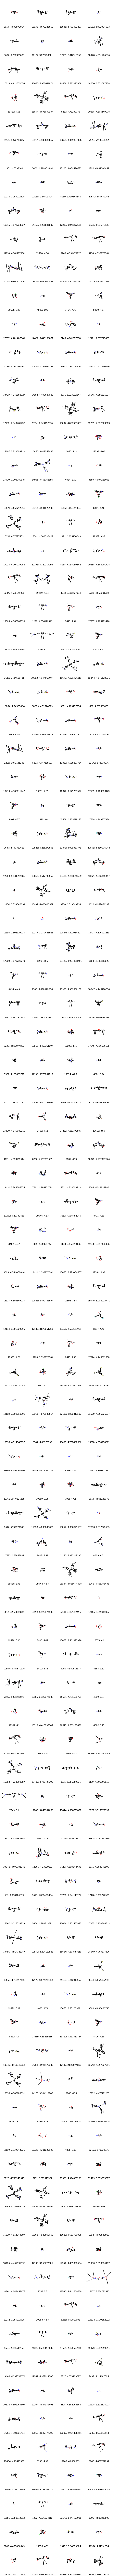

In [74]:
browse_image = draw_mols(df_of_fluorenes, "LogExtCoeff")
browse_image

In [36]:
def tag_index_dict_from_substructures_df (original_df, substructures_df):
    tag_dict = {}
    for tag_number in substructures_df['Tag'].unique():
        # Find the index (or loc) values for the current 'Tag' number
        index_values = original_df.index[original_df['Tag'] == tag_number].tolist()
        # Print the result
        print(f"Tag number {tag_number} has index values: {index_values}")
        tag_dict[tag_number] = index_values
    return tag_dict


In [38]:
tag_dict_fluorenes = tag_index_dict_from_substructures_df(optdata, df_of_fluorenes)

# save dictionary to pickle
with open('data/tag_dict.pickle', 'wb') as handle:
    pickle.dump(tag_dict_fluorenes, handle, protocol=pickle.HIGHEST_PROTOCOL)
# load dictionary from pickle
with open('data/tag_dict.pickle', 'rb') as handle:
    tag_dict_fluorenes = pickle.load(handle)
    

Tag number 3619 has index values: [23]
Tag number 15636 has index values: [30]
Tag number 15641 has index values: [39]
Tag number 12167 has index values: [158]
Tag number 3602 has index values: [165]
Tag number 12177 has index values: [180]
Tag number 12191 has index values: [189]
Tag number 18428 has index values: [337]
Tag number 10319 has index values: [380]
Tag number 15655 has index values: [429]
Tag number 14469 has index values: [458]
Tag number 14470 has index values: [474]
Tag number 19583 has index values: [506]
Tag number 15657 has index values: [522]
Tag number 5233 has index values: [560]
Tag number 10865 has index values: [601]
Tag number 8265 has index values: [605]
Tag number 10317 has index values: [688]
Tag number 10856 has index values: [705]
Tag number 2223 has index values: [750]
Tag number 1302 has index values: [759]
Tag number 3600 has index values: [871]
Tag number 12203 has index values: [873]
Tag number 1290 has index values: [914]
Tag number 12178 has index 

In [60]:
def get_smiles_and_loc_from_tag (tag, df):
    """
    Input: df, tag
    Output: smiles
    """
    smiles = df[df['Tag'] == tag]['Chromophore'].values[0]
    loc_number = df[df['Tag'] == tag]['Location'].values[0]
    return smiles, loc_number

In [68]:
def mol_from_tag (tag, df):
    """
    Return mol from Tag number of a particular df
    """
    # find index value for user entered tag number and draw the molecule
    loc_number = df.index[df['Tag'] == tag]
    print(f"Tag number {tag} has index value: {loc_number}")
    mol_from_tag = rdkit.Chem.MolFromSmiles(df.Chromophore[loc_number[0]])
    return mol_from_tag

Tag number 3619 has index value: Int64Index([23], dtype='int64')


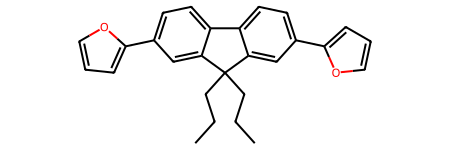

In [69]:
LogExtCoeff_tag_3619 = mol_from_tag(3619, optdata)
LogExtCoeff_tag_3619

In [17]:
# load dictionary from pickle
with open('data/tag_dict.pickle', 'rb') as handle:
    tag_dict = pickle.load(handle)

Tag number 3619 has index value: [23]


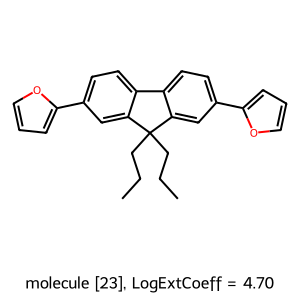

In [18]:
# find index value for user entered tag number and draw the molecule
tag_number = 3619
index_values = tag_dict[tag_number]
print(f"Tag number {tag_number} has index value: {index_values}")
mol_to_plot = rdkit.Chem.MolFromSmiles(optdata.Chromophore[index_values[0]])
rdkit.Chem.Draw.MolToImage(mol_to_plot, size=(300, 300), legend=f"molecule {index_values}, LogExtCoeff = {optdata.LogExtCoeff[23]:.2f}")



Index number 23 has Tag value: 3619


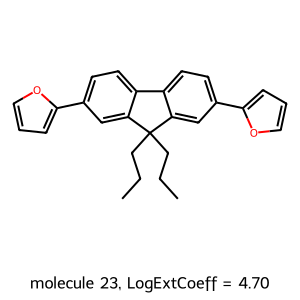

In [19]:
# find Tag value for user entered index number and draw the molecule
index_number = 23
tag_value = optdata.Tag[index_number]
print(f"Index number {index_number} has Tag value: {tag_value}")
mol_to_plot = rdkit.Chem.MolFromSmiles(optdata.Chromophore[index_number])
rdkit.Chem.Draw.MolToImage(mol_to_plot, size=(300, 300), legend=f"molecule {index_number}, LogExtCoeff = {optdata.LogExtCoeff[23]:.2f}")


In [49]:
def mol_from_index (df, index):
    """
    Return mol from index number
    """
    # find Tag value for user entered index number and draw the molecule
    tag_value = df.Tag[index]
    print(f"Index number {index} has Tag value: {tag_value}")
    mol_from_index = rdkit.Chem.MolFromSmiles(df.Chromophore[index])
    return mol_from_index

In [22]:
molecule_ids = [23, 6652, 180, 10906, 39, 7004, 11234, 84]
LogExtCoeff_23 = mol_from_index(optdata, 23)
LogExtCoeff_6652 = mol_from_index(optdata,6652)
LogExtCoeff_180 = mol_from_index(optdata, 180)
LogExtCoeff_10906 = mol_from_index(optdata, 10906)
LogExtCoeff_39 = mol_from_index(optdata, 39)
LogExtCoeff_7004 = mol_from_index(optdata, 7004)
LogExtCoeff_11234 = mol_from_index(optdata, 11234)
LogExtCoeff_84 = mol_from_index(optdata, 84)


Index number 23 has Tag value: 3619
Index number 6652 has Tag value: 12208
Index number 180 has Tag value: 12177
Index number 10906 has Tag value: 12185
Index number 39 has Tag value: 15641
Index number 7004 has Tag value: 15359
Index number 11234 has Tag value: 4086
Index number 84 has Tag value: 12729


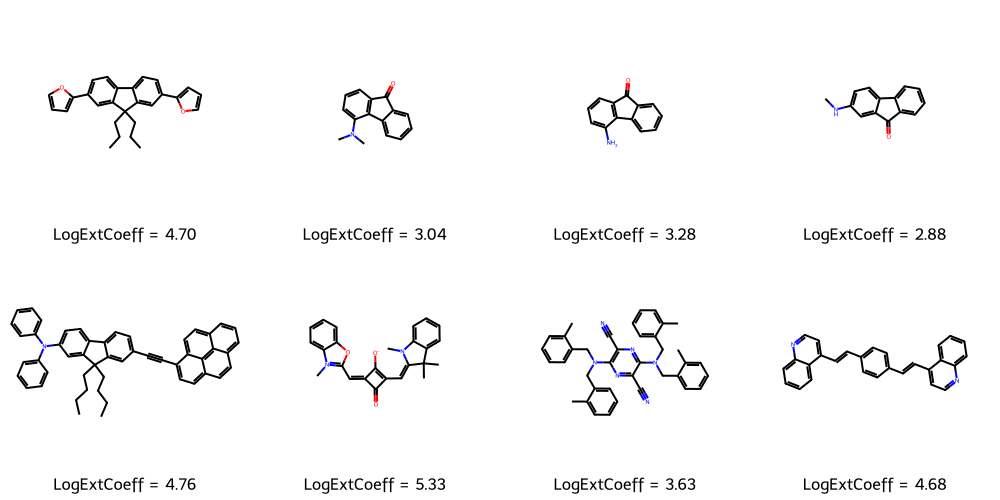

In [23]:
molstoplot = [LogExtCoeff_23, LogExtCoeff_6652, LogExtCoeff_180, LogExtCoeff_10906, LogExtCoeff_39, LogExtCoeff_7004, LogExtCoeff_11234, LogExtCoeff_84]

# Create legends for each molecule
legends = [f"LogExtCoeff = {optdata.LogExtCoeff[id]:.2f}" for id in molecule_ids]

image = rdkit.Chem.Draw.MolsToGridImage(molstoplot, molsPerRow=4, subImgSize=(250, 250), legends=legends, useSVG=False)

# Save the image to a file
# image.save("molecules.png")

# Display the image inline in the Jupyter notebook
image


In [80]:
def draw_molecule_from_dataframe(index, dataframe, property_1, property_2):
    # Extract information from dataframe
    smiles = dataframe.loc[index, "Chromophore"]
    tag = dataframe.loc[index, "Tag"]
    prop_1 = dataframe.loc[index, property_1]
    prop_2 = dataframe.loc[index, property_2]
    
    # Create the molecule from SMILES string
    mol = rdkit.Chem.MolFromSmiles(smiles)
    
    # Create the image of the molecule
    img = rdkit.Chem.Draw.MolToImage(mol, kekulize=True, bgcolor=(255,255,255))
    
    # Create a plot to display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    
    # Create the legend with the required information
    legend_text = f'loc: {index}\nTag: {tag}\n{property_1}: {prop_1:.3g}\n{property_2}: {prop_2:.3g}'
    plt.text(0, -20, legend_text, fontsize=12)
    
    # Display the plot
    plt.show()

# Example usage:
# Assume you have a dataframe named 'df'
# draw_molecule_from_dataframe(index=0, dataframe=df, property_1="property_1_column_name", property_2="property_2_column_name")


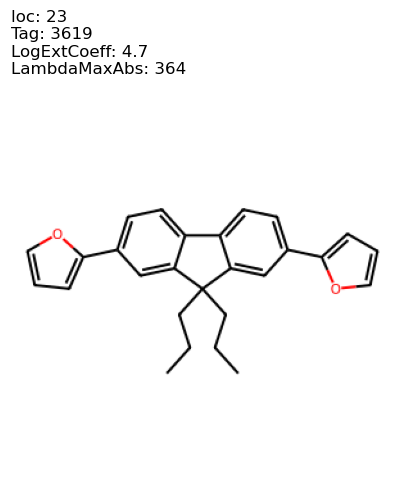

In [81]:
draw_molecule_from_dataframe(index=23, dataframe=optdata_LogExtCoeff, property_1="LogExtCoeff", property_2="LambdaMaxAbs")